# Catching close encounters using exceptions
Sometimes one is interested in catching a close encounter between two planets. This can easily be done with REBOUND. What you do when a close encounter happens is up to you.

Some integrators are better suited to simulate close encounters than others. For example, the non-symplectic integrator IAS15 has an adaptive timestep scheme that resolves close encounters very well. Integrators that use a fixed timestep like WHFast are more likely to miss close encounters.

Let's start with a two-planet system that will go unstable on a short timescale (we'll also assign them arbitrary IDs for later use):

In [1]:
import rebound
import numpy as np
def setupSimulation():
    sim = rebound.Simulation()
    sim.integrator = "ias15" # IAS15 is the default integrator, so we don't need this line
    sim.add(m=1., id=1)
    sim.add(m=1e-3,a=1., id=5)
    sim.add(m=5e-3,a=1.25, id=7)
    sim.move_to_com()
    return sim

Let's integrate this system for 100 orbital periods.

In [2]:
sim = setupSimulation()
sim.integrate(100.*2.*np.pi)

Rebound exits the integration routine normally. We can now explore the final particle orbits:

In [3]:
for o in sim.calculate_orbits():
    print(o)

<rebound.Orbit instance, a=4.85243308061552 e=0.7213519193297855>
<rebound.Orbit instance, a=1.041543482904872 e=0.12343600515994291>


We see that the orbits of both planets changed significantly and we can already speculate that there was a close encounter.

Let's redo the simulation, but this time set the `sim.exit_min_distance` flag for the simulation. If this flag is set, then REBOUND calculates the minimum distance between all particle pairs each timestep. If the distance is less than `sim.exit_min_distance`, then the integration is stopped and an exception thrown. Here, we'll use the [Hill radius](http://en.wikipedia.org/wiki/Hill_sphere) as the criteria for a close encounter. It is given by $r_{\rm Hill} \approx a \sqrt{\frac{m}{3M}}$, which is approximately 0.15 AU in our case. 

This setup allows us to instead catch the exception and deal with it in a customized way.  As a first example, let's catch the exception with a `try`-`except` block, and simply print out the error message. Additionally, let's store the particles' separations while we're integrating:

In [4]:
sim = setupSimulation() # Resets everything
sim.exit_min_distance = 0.15
Noutputs = 1000
times = np.linspace(0,100.*2.*np.pi,Noutputs)
distances = np.zeros(Noutputs)
ps = sim.particles # ps is now an array of pointers. It will update as the simulation runs.
try:
    for i,time in enumerate(times):
        sim.integrate(time)
        dx = ps[1].x - ps[2].x
        dy = ps[1].y - ps[2].y
        dz = ps[1].z - ps[2].z
        distances[i] = np.sqrt(dx*dx+dy*dy+dz*dz)
except rebound.Encounter as error:
    print(error)

Two particles had a close encounter (d<exit_min_distance).


The `Encounter` does currently not tell you wich particles had a close encounter. But you can easily search for the pair yourself (see below). 

Here, we already know which bodies had a close encounter (the two planets), so let's plot their separation.

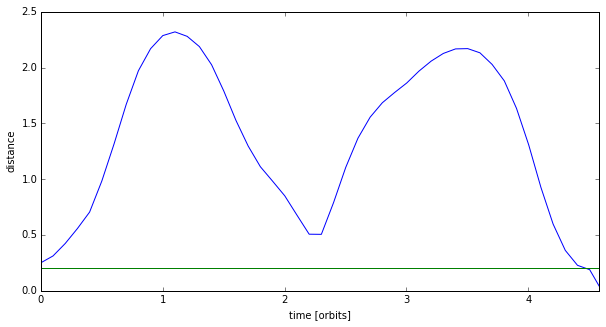

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.set_xlabel("time [orbits]")
ax.set_xlim([0,sim.t/(2.*np.pi)])
ax.set_ylabel("distance")
plt.plot(times/(2.*np.pi), distances);
plt.plot([0.0,12],[0.2,0.2]) # Plot our close encounter criteria;

We did indeed find the close enounter correctly. We can now search for the two particles that collided and, for this example, merge them. To do that we'll first calculate our new merged planet coordinates, then remove the two particles that collided from REBOUND and finally add the new particle.

In [6]:
import copy
from itertools import combinations
def mergeParticles(sim):
    # Find two closest particles
    min_d2 = 1e9 # large number
    particles = sim.particles
    for p1, p2 in combinations(particles,2):
        dx = p1.x - p2.x
        dy = p1.y - p2.y
        dz = p1.z - p2.z
        d2 = dx*dx + dy*dy + dz*dz
        if d2<min_d2:
            min_d2 = d2
            cp1 = p1
            cp2 = p2
    
    # Merge two closest particles
    mergedPlanet = rebound.Particle()
    mergedPlanet.m  = cp1.m + cp2.m
    mergedPlanet.x  = (cp1.m*cp1.x  + cp2.m*cp2.x) /mergedPlanet.m
    mergedPlanet.y  = (cp1.m*cp1.y  + cp2.m*cp2.y) /mergedPlanet.m
    mergedPlanet.z  = (cp1.m*cp1.z  + cp2.m*cp2.z) /mergedPlanet.m
    mergedPlanet.vx = (cp1.m*cp1.vx + cp2.m*cp2.vx)/mergedPlanet.m
    mergedPlanet.vy = (cp1.m*cp1.vy + cp2.m*cp2.vy)/mergedPlanet.m
    mergedPlanet.vz = (cp1.m*cp1.vz + cp2.m*cp2.vz)/mergedPlanet.m
    mergedPlanet.id = cp1.id 
    id1 = p1.id
    id2 = p2.id
    sim.remove(id=id1)
    sim.remove(id=id2)
    sim.add(mergedPlanet)

sim = setupSimulation() # Resets everything
sim.exit_min_distance = 0.15
print("Number of particles at the beginning of the simulation: %d."%sim.N)
for i,time in enumerate(times):
    try:
        sim.integrate(time)
    except rebound.Encounter as error:
        print(error)
        mergeParticles(sim)
print("Number of particles at the end of the simulation: %d."%sim.N)

Number of particles at the beginning of the simulation: 3.
Two particles had a close encounter (d<exit_min_distance).
Number of particles at the end of the simulation: 2.
